In [3]:
from tqdm import tqdm
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# helper function
def remove_prefix(text: str, prefix: str) -> str:
    if text.startswith(prefix):
        return text[len(prefix):]
    raise ValueError(prefix)

# helper function
def remove_suffix(text: str, suffix: str) -> str:
    if text.endswith(suffix):
        return text[len(suffix):]
    raise ValueError(suffix)

# global variables
TOTAL_SEQS = 6739258
PREFIX = 'TGCATTTTTTTCACATC'
SUFFIX = 'GGTTACGGCTGTT'
MAX_SEQ_LEN = 142 - len(PREFIX) - len(SUFFIX)  # 112
nuc_map = {k: i for i, k in enumerate(['A', 'C', 'T', 'G', 'N'])}

def kmerize(filename="./data/train_sequences.txt", stride=1, size=4):
    """
    Generate kmers for specified subset of sequences.
    :param:
           str filename: file with sequences.
           int stride: slide of the window for kmer generation.
           int size: size of the kmer.
    :return:
            pd.DataFrame: Pandas object with row pair as sequence and the corresponding kmer.
            list exprs: expressions of promoter sequences.
    """
    sequences, kmers, exprs = [], [], []
    with open(filename) as f:
        for i, line in enumerate(tqdm(f.readlines())):
            if i == 10000:
                break
            seq, expr = line.split('\t')
            exprs.append(float(expr.replace("\n", "")))
            # keep original sequence 
            sequences.append(seq)
            seq = remove_suffix(remove_prefix(seq, PREFIX), SUFFIX)
            try:
                kmer = [seq[i:(i+size)] for i in range(0, stride, len(seq)) if len(seq[i:(i+size)]) == size]
                kmer = ",".join(kmer)
                kmers.append(kmer)
            except IndexError:
                pass
    print(kmers)
    database = pd.DataFrame({'sequence': sequences, "kmers": kmers})
    exprs = np.array(exprs, dtype=np.float16)
    return database, exprs

def tokenize(size=4, filename="./data/train_sequences.txt"):
    """
    Calculate frequency for each kmer given sequence.
    :param:
           int size: length of each kmer.
           str filename: file with sequences.
    :return:
            pd.DataFrame: Pandas object consisting of kmer frequencies indexed by sequences.
            list exprs: expressions of promoter sequences.
    """
    database, exprs = kmerize(filename=filename, stride=1, size=size)
    vectorizer = CountVectorizer()
    vectorizer.fit(database["kmers"])
    data = vectorizer.transform(database["kmers"])
    vectors = pd.DataFrame(data.toarray(), database["sequence"].values, vectorizer.get_feature_names())
    return vectors, exprs

In [65]:
x = np.empty((6739258, MAX_SEQ_LEN * 4), np.float16)
y = np.empty(6739258, np.float16)

with open('data/train_sequences.txt', 'r') as f:
    for i, line in enumerate(tqdm(f.readlines())):
            seq, expr = line.split('\t')
            seq = remove_suffix(remove_prefix(seq, PREFIX), SUFFIX)
            nuc_idx = np.array([nuc_map[s] for s in seq], dtype=int)
            pos_idx = np.arange(nuc_idx.size)[nuc_idx != 4]
            nuc_idx = nuc_idx[nuc_idx != 4]
            one_hot = np.zeros((MAX_SEQ_LEN, 4))
            one_hot[pos_idx, nuc_idx] = 1 / MAX_SEQ_LEN
            x[i] = one_hot.ravel()
            y[i] = float(expr)

100%|██████████| 6739258/6739258 [07:36<00:00, 14755.92it/s]


In [2]:
ls -l data

total 1588968
-rw-r--r--@ 1 kaanguney.keklikci  staff    8176845 Jul 16 16:51 test_sequences.txt
-rw-r--r--@ 1 kaanguney.keklikci  staff  805369640 Jul 16 16:16 train_sequences.txt


In [72]:
X_train, X_valid, y_train, y_valid = train_test_split(x, y, test_size=0.33, random_state=42)

In [21]:
del vectors, exprs

In [73]:
rf = RandomForestRegressor(n_estimators=300, max_depth=None, min_samples_split=2, bootstrap=False, verbose=2)

In [ ]:
rf.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 300


In [42]:
model_name = "rf_model"
joblib.dump(rf, model_name)

['rf_model']

In [43]:
r2_score(y_train, rf.predict(X_train))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.4s finished


0.02480385991885725

In [44]:
mean_squared_error(y_train, rf.predict(X_train))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.3s finished


5.232786129852676

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

In [46]:
vectors, exprs = tokenize(filename="./data/test_sequences.txt")

 14%|█▍        | 10000/71103 [00:00<00:00, 260559.47it/s]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.2s finished


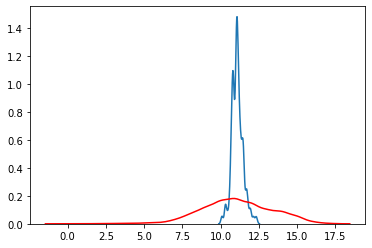

In [47]:
plt.plot(figsize=(20, 2))
sns.kdeplot(rf.predict(X_valid))
sns.kdeplot(y_valid, color = "r")
plt.show()

In [ ]:
r2_score(y_valid)